In [27]:
import warnings
from utils.plotting_helpers import plot_weights
from environements.portfolio_optimization_env_flat import PortfolioOptimizationEnvFlat
import matplotlib as mpl
from utils.portfolio_trainer import PortfolioOptimization
from pandas import read_csv
from utils.feature_engineer import FeatureEngineer
from utils.helpers import data_split
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
from utils.plotting_helpers import plot_mvo_weights
import utils.mean_variance_optimization as mvo
df_dow = read_csv('./data/dow.csv')
from utils.mean_variance_optimization import mvo_data

# mpl.rcParams['figure.dpi'] = 300
import math
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')
warnings.filterwarnings("ignore")


def linear_schedule(initial_value):
    def scheduler(progress_remaining):
        return initial_value * progress_remaining
    return scheduler

In [28]:
df = df_dax.copy()

df = df_dow[df_dow.tic.isin([ 'AXP', 'DIS', 'GS', 'MMM', 'UNH','MCD','CAT','CRM','V','AMGN','TRV','MSFT'])]
# df = df[df.tic.isin(['ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BMW.DE', 'CON.DE', 'DBK.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE', 'VOW3.DE'])]
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'
INDICATORS = [
    "macd",
    "rsi_30",
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list=INDICATORS,
                     use_turbulence=False,
                     user_defined_feature=True)

processed_prcies = fe.preprocess_data(df.query('date>"2000-01-01"'))
cleaned_data = processed_prcies.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf, 0)
stock_dimension = len(cleaned_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 10


In [29]:
# Compute exponentially weighted std of log returns
for window in [21, 42, 63]:
    cleaned_data[f'std_return_{window}'] = cleaned_data.groupby('tic')['log_return'] \
        .transform(lambda x: x.ewm(span=window, min_periods=window,adjust=False).std() )
# Compute exponentially weighted std of closing prices for MACD normalization
cleaned_data['ewma_std_price_63'] = cleaned_data.groupby('tic')['close'] \
    .transform(lambda x: x.ewm(span=63, min_periods=60,adjust=False).std())

# Normalize MACD by price volatility
cleaned_data['macd_normal'] = cleaned_data['macd'] / cleaned_data['ewma_std_price_63']

# Rolling cumulative log returns over different periods
for window in [21, 42, 63]:
    cleaned_data[f'return_sum_{window}'] = cleaned_data.groupby('tic')['log_return'] \
        .transform(lambda x: x.ewm(span=window, min_periods=window,adjust=False).mean())

# Normalize rolling log returns by their respective volatilities
for window in [21, 42, 63]:
    cleaned_data[f'r_{window}'] = cleaned_data[f'return_sum_{window}'] / cleaned_data[f'std_return_{window}']
cleaned_data['rsi_30'] = cleaned_data['rsi_30']/100

<Axes: xlabel='date'>

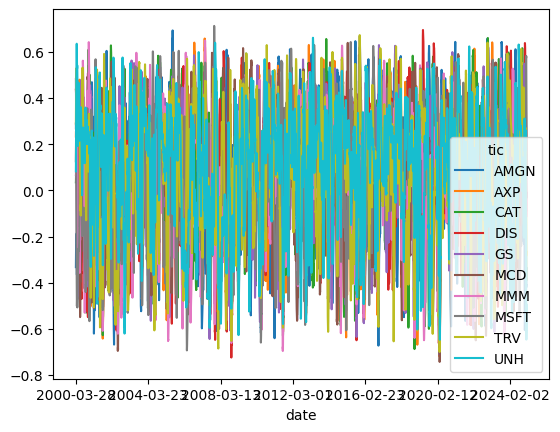

In [30]:
%matplotlib inline

pv = cleaned_data.pivot_table(index='date',columns='tic',values='macd_normal')
pv.plot()

In [ ]:
%matplotlib inline
pv.plot()

In [31]:
covs = mvo.mvo_data(cleaned_data,risk_model='sample_cov')

TypeError: mvo_data() missing 2 required positional arguments: 'TEST_START_DATE' and 'TEST_END_DATE'

In [10]:
cleaned_data = covs.fillna(0)
cleaned_data.isna().sum()

Unnamed: 0           0
date                 0
open                 0
high                 0
low                  0
close                0
volume               0
tic                  0
day                  0
macd                 0
rsi_30               0
return               0
log_return           0
std_return_21        0
std_return_42        0
std_return_63        0
ewma_std_price_63    0
macd_normal          0
return_sum_21        0
return_sum_42        0
return_sum_63        0
r_21                 0
r_42                 0
r_63                 0
time                 0
cov_list             0
corr_list            0
returns              0
dtype: int64

In [36]:
with open('./data/dow_normal_processed.pkl', 'wb') as file: 
    pickle.dump(cleaned_data, file) 

In [2]:
with open('./data/dow_processed.pkl', 'rb') as file: 
    cleaned_data = pickle.load(file)

In [ ]:
with open('./data/dow_normal_processed.pkl', 'rb') as file:
     = pickle.load(file)

In [39]:
cleaned_data.isna().sum()

Unnamed: 0             0
date                   0
open                   0
high                   0
low                    0
close                  0
volume                 0
tic                    0
day                    0
macd                   0
rsi_30                 0
return                 0
log_return             0
std_return_21        200
std_return_42        410
std_return_63        620
ewma_std_price_63    590
macd_normal          590
return_sum_21        200
return_sum_42        410
return_sum_63        620
r_21                 200
r_42                 410
r_63                 620
dtype: int64

In [29]:
cleaned_data['rsi_30']

0        0.475448
1        0.454924
2        0.650913
3        0.411130
4        0.528277
           ...   
60355    0.468390
60356    0.494727
60357    0.478258
60358    0.456212
60359    0.408121
Name: rsi_30, Length: 60360, dtype: float64

In [20]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2020-12-30'

VALIDATION_START_DATE = '2021-01-01'
VALIDATION_END_DATE = '2021-12-30'

TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2024-12-30'
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())


In [21]:
pv_simple_return = train_data.pivot_table(index='date',values='return',columns='tic')
pv_simple_log_return = train_data.pivot_table(index='date',values='log_return',columns='tic')
pv_simple_rsi = train_data.pivot_table(index='date',values='rsi_30',columns='tic')
pv_simple_macd_normal= train_data.pivot_table(index='date',values='macd_normal',columns='tic')
pv_simple_std= train_data.pivot_table(index='date',values='ewma_std_price_63',columns='tic')
pv_m_21= train_data.pivot_table(index='date',values='return_sum_21',columns='tic')



<Axes: xlabel='date'>

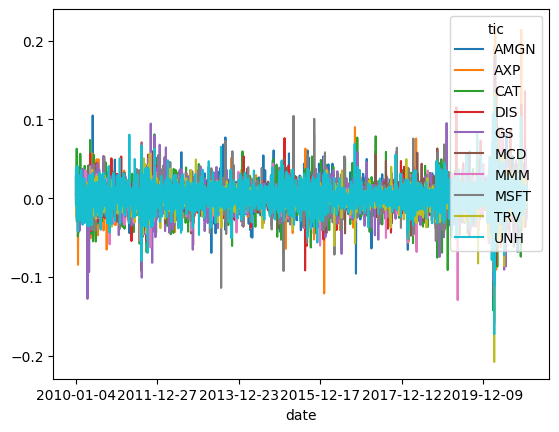

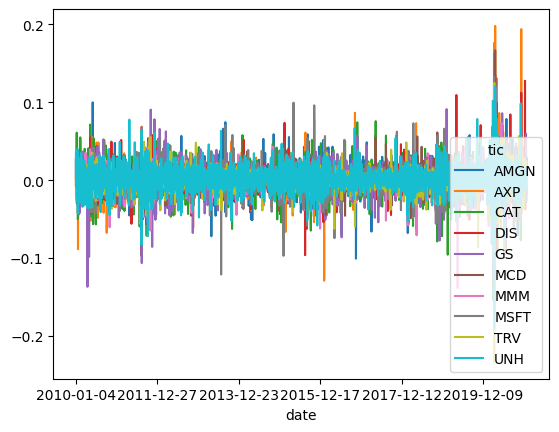

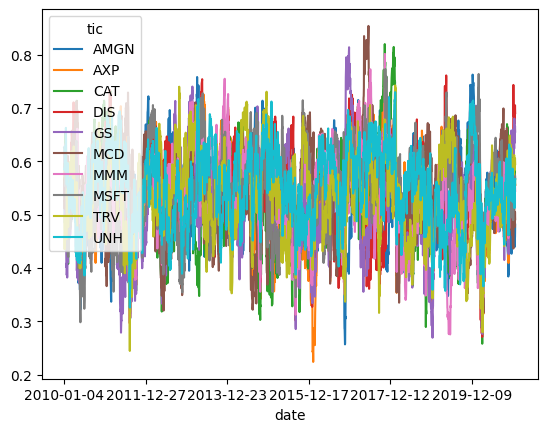

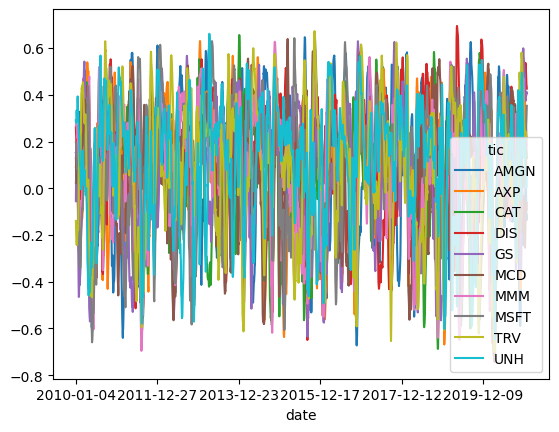

In [22]:
%matplotlib inline

pv_simple_return.plot()
pv_simple_log_return.plot()
pv_simple_rsi.plot()
pv_simple_macd_normal.plot()



# Proximal Policy Optimization

{'gamma': 0.9, 'learning_rate': 0.0001, 'buffer_size': 300000, 'batch_size': 124, 'action_noise': NormalActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard_log/close_log_return_r_21_r_42_r_63_macd_rsi_30_window_size_21_0_flat_state/td3_2
Initial portfolio value:250000
Final portfolio value: 1361501.5
Final accumulative portfolio value: 5.446005821228027
Maximum DrawDown: -0.3490563204756685
Sharpe ratio: 0.9043975125309601


KeyboardInterrupt: 

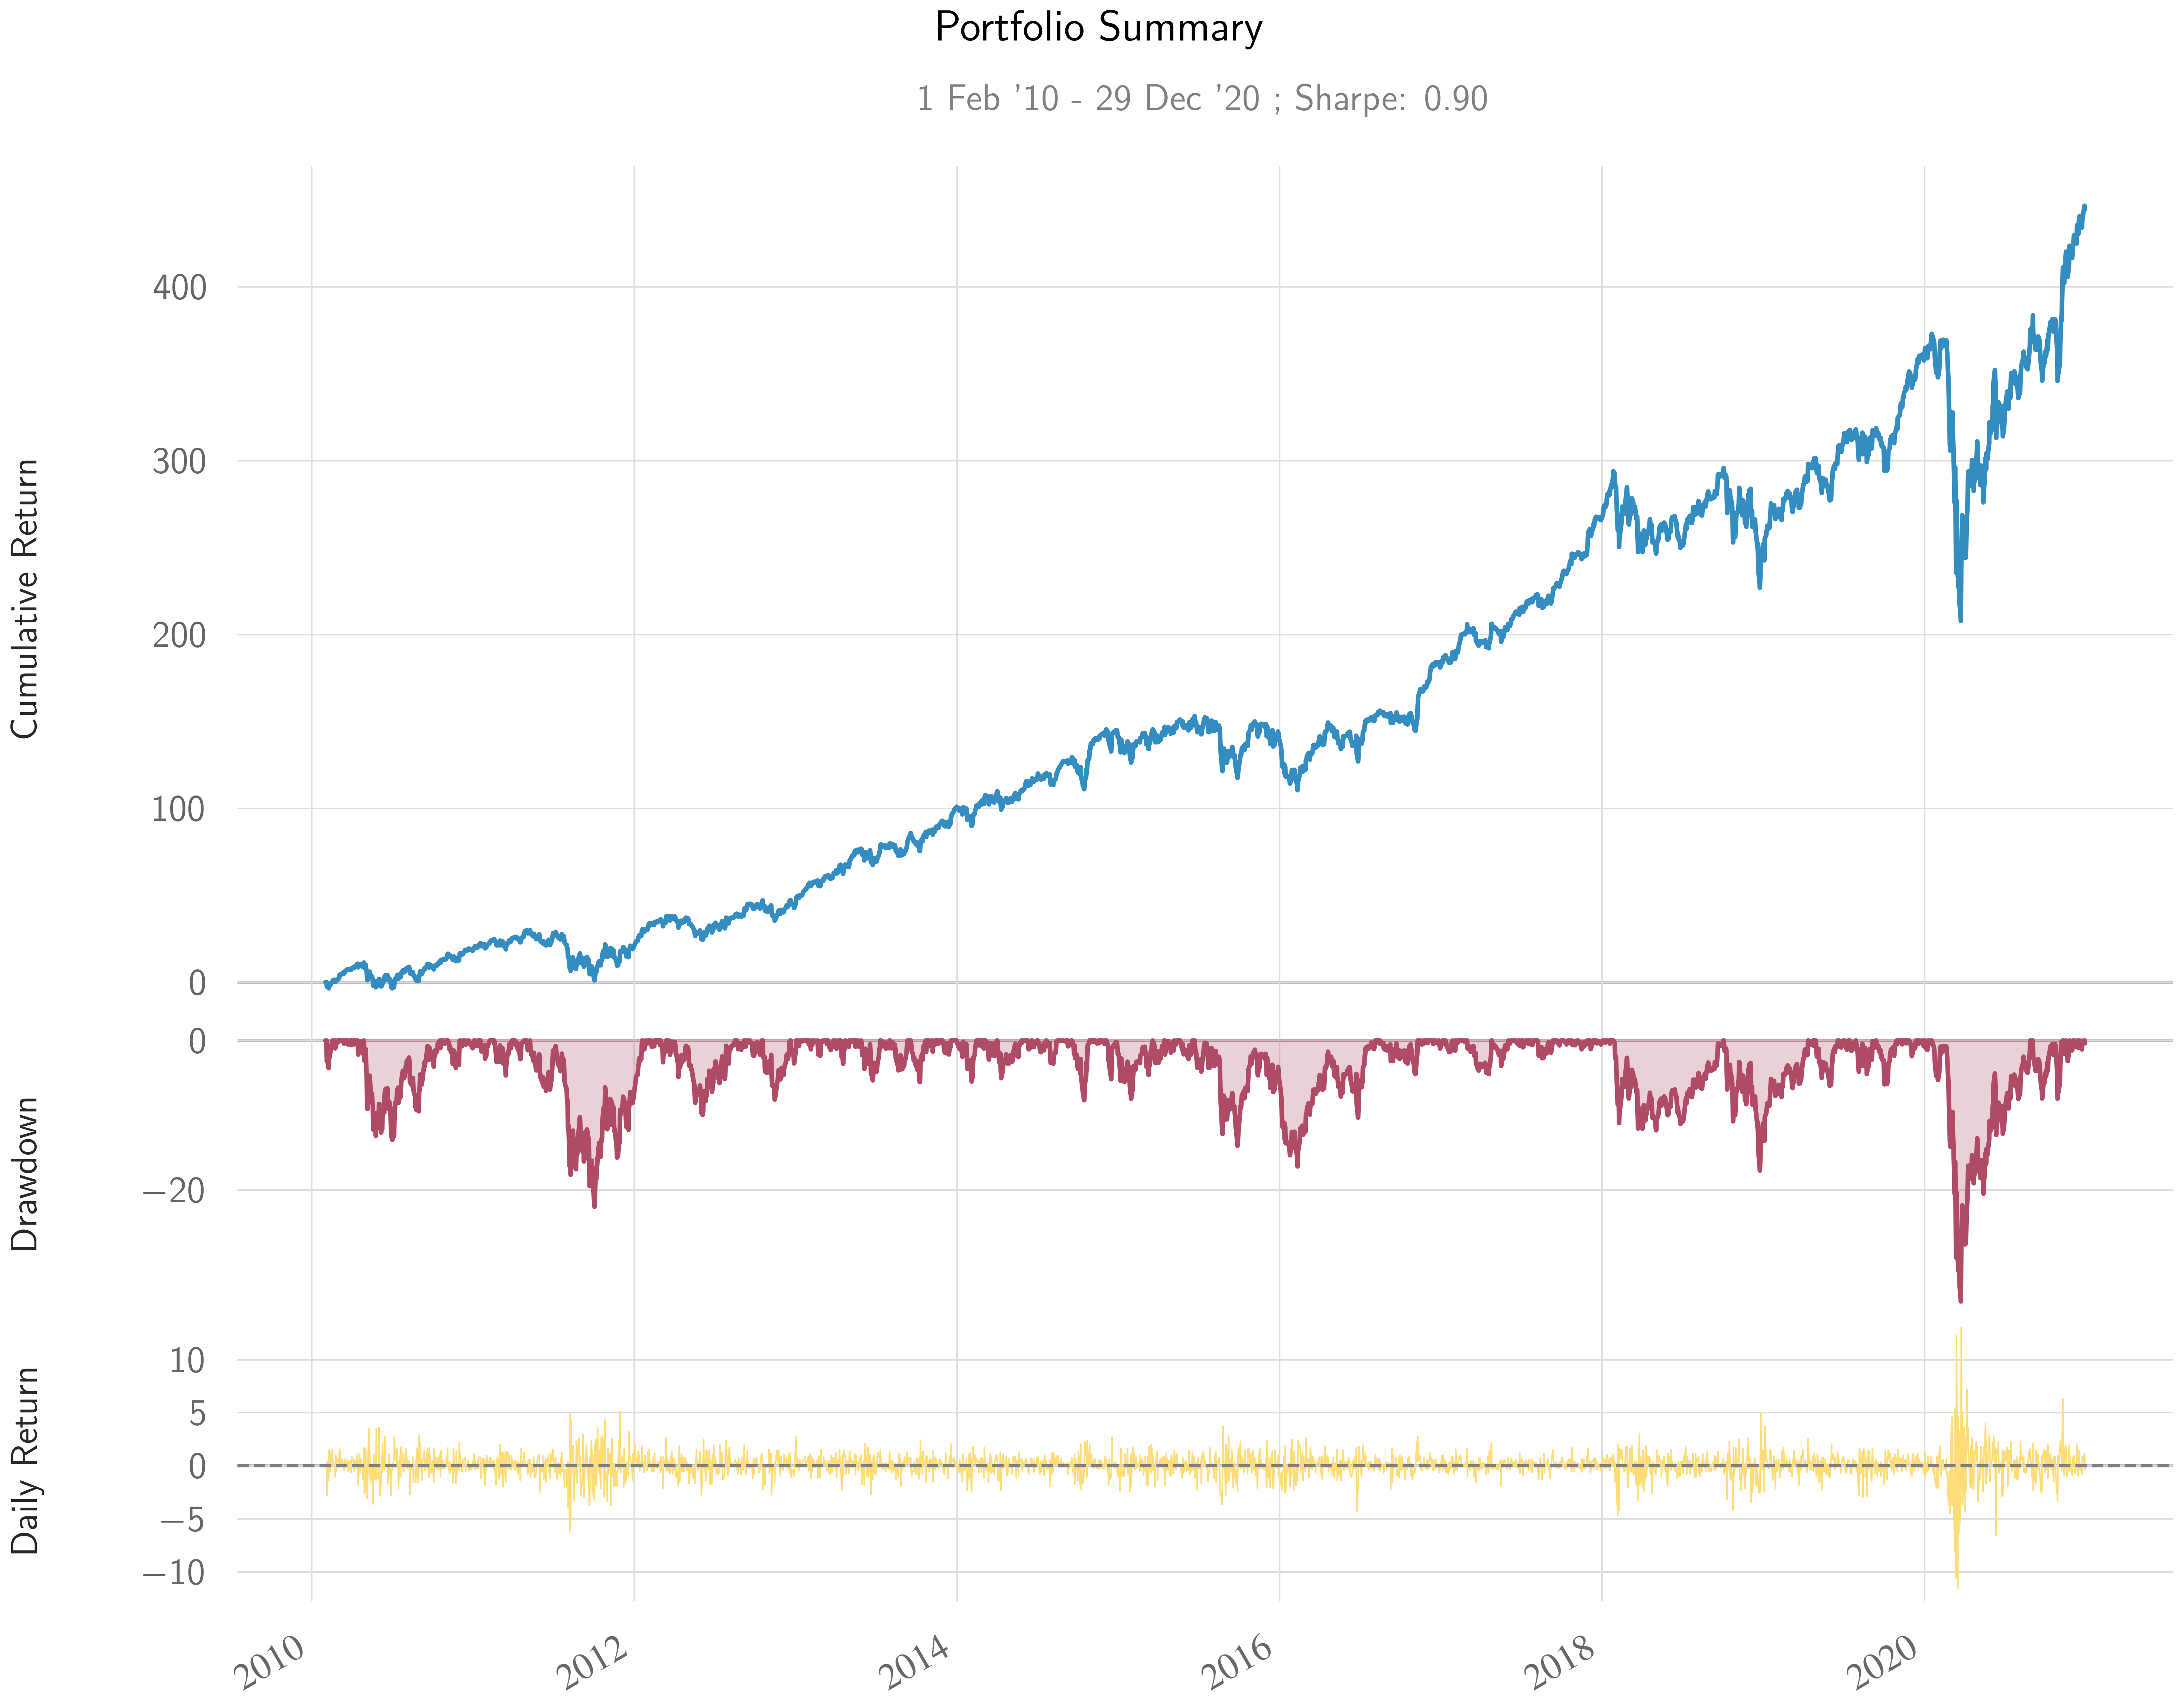

In [46]:
%matplotlib inline

import torch
from torch import nn

from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
activ_func = nn.SiLU
use_sharpe_reward = False
optimizer = PortfolioOptimization(
    transaction_fee=0, comission_fee_model=None,
    tag="flat_state", sharp_reward=use_sharpe_reward, last_weight=False, remove_close=True,flatten_state=False,
    add_cash=False, env=PortfolioOptimizationEnv
)
optimizer.train_model(train_data,
                        validation_data,
                        features=["close", "log_return", "r_21", "r_42", "r_63",
                                "macd", "rsi_30"
                                ],
                        model_name="td3",
                        args={'gamma': 0.90, 'learning_rate': 1e-4,
                            "buffer_size": 300_000, "batch_size": 124,
                            "action_noise": "normal"},
                        window_size=21,
                        policy_kwargs=dict(
                            activation_fn=activ_func,
                        ),
                        iterations=1000_000)

# test_env = optimizer.create_environment(test_data,features=[
# "close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi_30"
#                                   ],window=21)
# ppo_test_result = optimizer.load_from_file(
#     'td3',test_env, 
#     cwd="data/td3_close_log_return_r_21_r_42_r_63_macd_rsi_30_window_size_21_0.001_td3_state_corr_dow/td3_100000_steps"
#     ,deterministic=True)

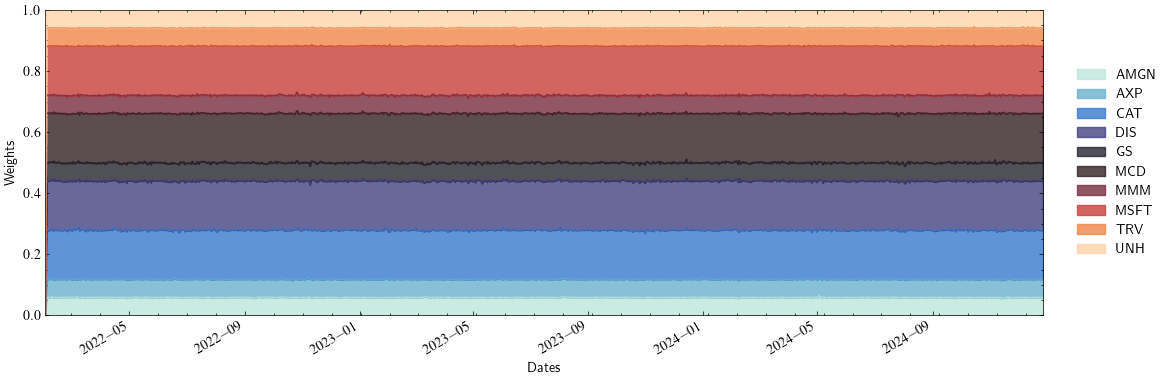

In [20]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

# TD3

In [33]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0, comission_fee_model=None,
    tag="flat_state", sharp_reward=False, last_weight=False, remove_close=True,flatten_state=False,
    add_cash=False, env=PortfolioOptimizationEnv
)
# optimizer.train_model(train_data,
#                       validation_data,
#                       features=["close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi_30","corr_list"
#                                 ],
#                       model_name="ppo",
#                       args={"n_steps":  1024, "batch_size": 64, 'learning_rate': 1e-4,
#                             'gamma': 0.85, 'gae_lambda': 0.85, 'ent_coef': 0.05},
#                       window_size=5,
#                       iterations=1000_000)

test_env = optimizer.create_environment(test_data,features=[
                                "close", "log_return", "r_21", "r_42", "r_63",
                                "macd", "rsi_30"
                                  ],window=21)
td3_test_result = optimizer.load_from_file(
    'td3',test_env, 
    cwd="data/td3_close_log_return_r_21_r_42_r_63_macd_rsi_30_window_size_21_0.001_td3_state_corr_dow_2/td3_510000_steps"
    ,deterministic=True)

Successfully load model data/td3_close_log_return_r_21_r_42_r_63_macd_rsi_30_window_size_21_0.001_td3_state_corr_dow_2/td3_510000_steps
Initial portfolio value:250000
Final portfolio value: 358133.9375
Final accumulative portfolio value: 1.4325357675552368
Maximum DrawDown: -0.1963252569478856
Sharpe ratio: 0.8118503641666363


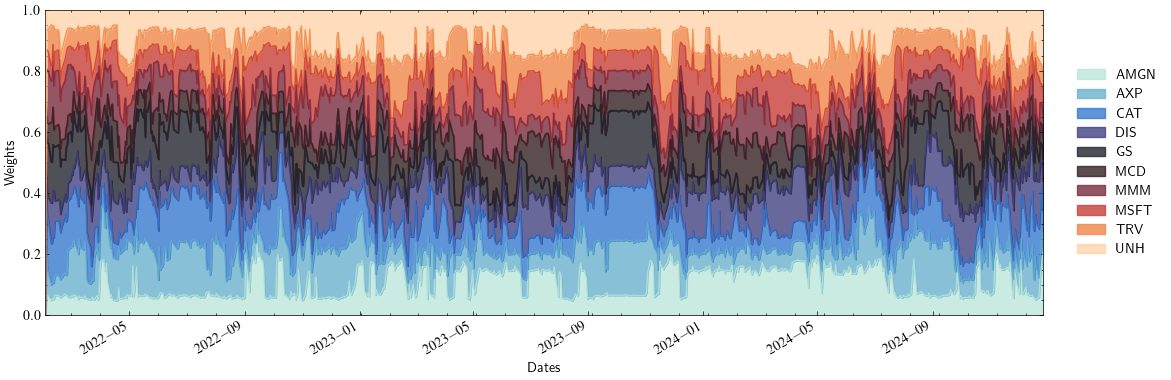

In [34]:
from utils.plotting_helpers import plot_weights
plot_weights(td3_test_result[0].weights, td3_test_result[0].date, td3_test_result[1],add_cash=False)

# Mean Variance Optimization

In [6]:
covariances = data_split(cleaned_data,TEST_START_DATE,TEST_END_DATE)
min_variacen_portfolio = mvo.mean_variance_optimization(covariances,commission_fee=0,window=21)

Initial portfolio value:1000000
Final portfolio value: 1074859.625
Final accumulative portfolio value: 1.074859619140625
Maximum DrawDown: -0.3180998086793213
Sharpe ratio: 0.23734356615292893


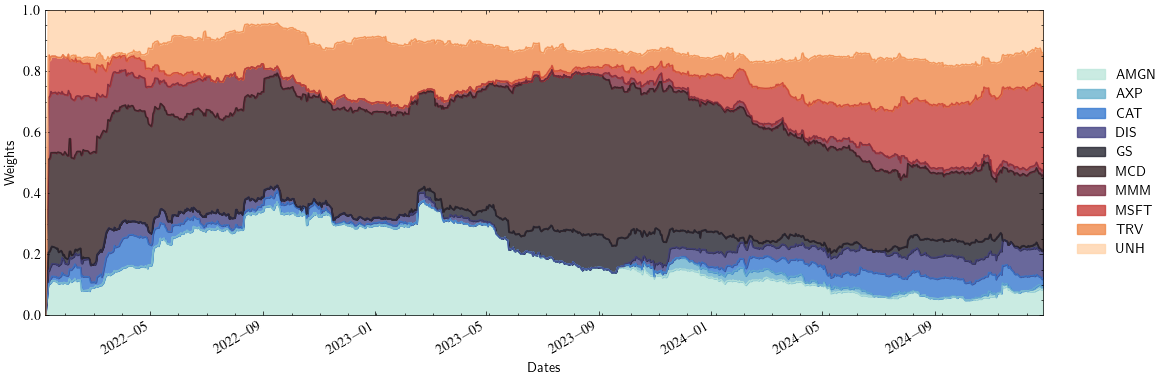

In [11]:
%matplotlib inline
plot_weights(min_variacen_portfolio[0].weights, min_variacen_portfolio[0].date, min_variacen_portfolio[1],add_cash=False)

Initial portfolio value:1000000
Final portfolio value: 1094981.0
Final accumulative portfolio value: 1.0949809551239014
Maximum DrawDown: -0.26194132371388257
Sharpe ratio: 0.2570121656975873


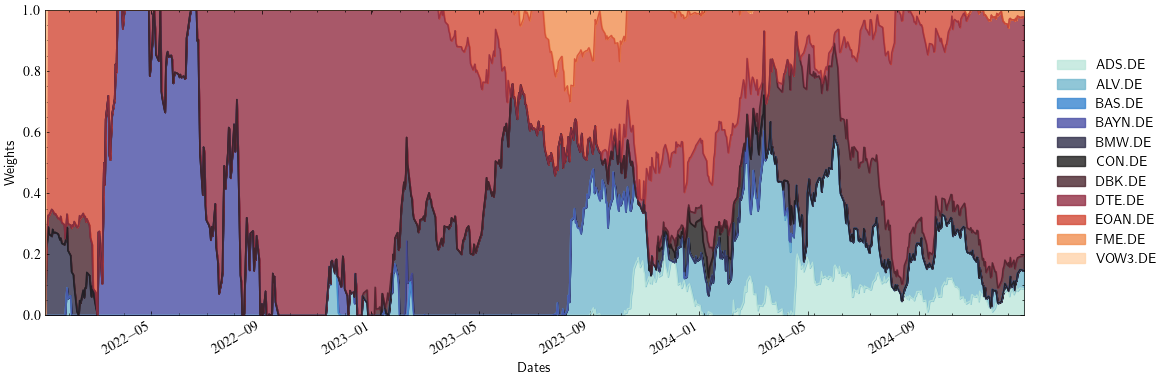

In [7]:
result_sharpe = mvo.mean_variance_optimization(covariances,commission_fee=0,objective='sharpe')
%matplotlib inline
plot_weights(result_sharpe[0].weights, result_sharpe[0].date, result_sharpe[1],add_cash=False)

PPO WITHOUT WEIGHT

Use normalization

In [ ]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0.00, comission_fee_model=None, vectorize=False, normalize=None,
    tag="ppo_alternative_state_11_asset", sharp_reward=False, last_weight=False, remove_close=True,
    add_cash=False, env=PortfolioOptimizationEnv
    )
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","momentum_return_21_normal"
#                                   ,"momentum_return_42_normal","momentum_return_63_normal",
#                                   "macd_normal","rsi_normal"
#                                   ],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 64,'learning_rate':1e-4,'gamma':0.90 ,'gae_lambda': 0.85, 'ent_coef': 0.05},
#                         window_size=60,
#                         iterations=400_000)
test_env = optimizer.create_environment(test_data,features=["close", "log_return", "r_21_normal",
                                "r_42_normal", "r_63_normal", "r_252_normal", "macd_normal", "rsi_normal"
                                  ],window=60)
ppo_test_result = optimizer.load_from_file(
    'ppo',test_env, 
    cwd="data\ppo_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_portfolio_return_ppo\ppo_260000_steps"
    ,deterministic=True)


Successfully load model data\ppo_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_portfolio_return_ppo\ppo_260000_steps
Initial portfolio value:250000
Final portfolio value: 262199.625
Final accumulative portfolio value: 1.0487984418869019
Maximum DrawDown: -0.2204810883074637
Sharpe ratio: 0.23582026443643747


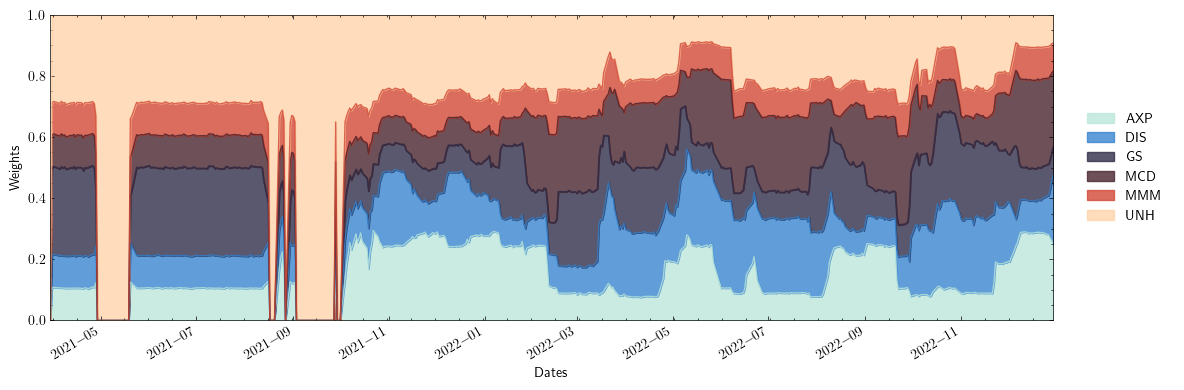

In [ ]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

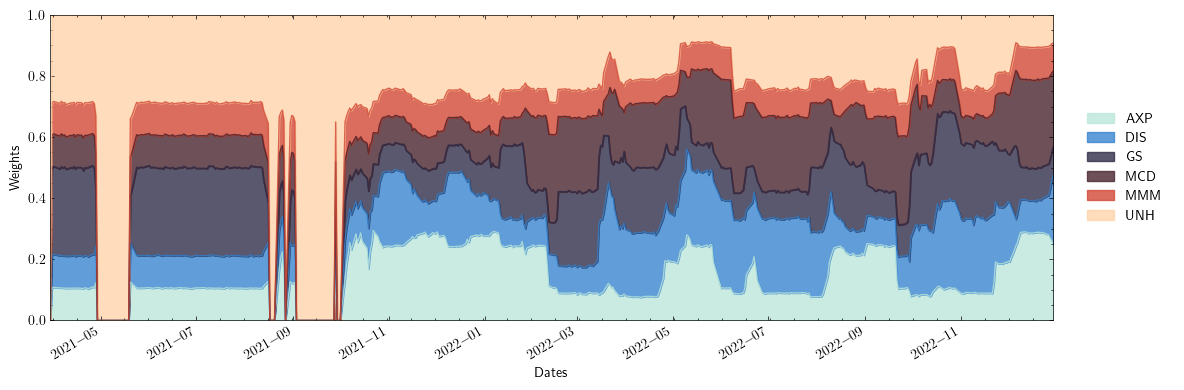

In [ ]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

In [ ]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0.00, comission_fee_model=None, vectorize=False, normalize=None,
    tag="ppo_alternative_state_11_asset", sharp_reward=False, last_weight=False, remove_close=True,
    add_cash=False, env=PortfolioOptimizationEnv
    )
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","momentum_return_21_normal"
#                                   ,"momentum_return_42_normal","momentum_return_63_normal",
#                                   "macd_normal","rsi_normal"
#                                   ],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 64,'learning_rate':1e-4,'gamma':0.90 ,'gae_lambda': 0.85, 'ent_coef': 0.05},
#                         window_size=60,
#                         iterations=400_000)
test_env = optimizer.create_environment(test_data,features=["close", "log_return", "r_21_normal",
                                "r_42_normal", "r_63_normal", "r_252_normal", "macd_normal", "rsi_normal"
                                  ],window=60)
a2c_test_result = optimizer.load_from_file(
    'a2c',test_env, 
    cwd="data/a2c_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_a2c_ret/a2c_130000_steps"
    ,deterministic=True)


Successfully load model data/a2c_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_a2c_ret/a2c_130000_steps
Initial portfolio value:250000
Final portfolio value: 192655.375
Final accumulative portfolio value: 0.7706214785575867
Maximum DrawDown: -0.34089284004725384
Sharpe ratio: -0.5424350110453228


# Buy and Hold

In [18]:
from environements.portfolio_optimization_env import PortfolioOptimizationEnv


stock_dimension = len(test_data.tic.unique())
environment_train_buy_and_hold_sp500 = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0,
    time_window=5,
    features = ["close","return"],
    normalize_df=None,
    add_cash=False
)
terminated = False

environment_train_buy_and_hold_sp500.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated,_, _ = environment_train_buy_and_hold_sp500.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1339321.375
Final accumulative portfolio value: 1.3393213748931885
Maximum DrawDown: -0.18659573293420295
Sharpe ratio: 0.6890450873214902


In [23]:
result_sharpe[0]

,date,daily_return,account,weights
0,2021-01-04,0.000000,1.000000e+06,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2021-01-05,0.005392,1.005392e+06,"[0.0, 0.0, 0.40079823, 0.46543342, 0.0, 0.0, 0..."
2,2021-01-06,0.022249,1.027761e+06,"[0.0, 0.0, 0.43394077, 0.45886135, 0.0, 0.0, 0..."
3,2021-01-07,0.000619,1.028398e+06,"[0.0, 0.0, 0.6583775, 0.32502544, 0.01659708, ..."
4,2021-01-08,-0.000184,1.028208e+06,"[0.0, 0.0, 0.6016036, 0.27004594, 0.10730912, ..."
...,...,...,...,...
748,2023-12-22,0.004973,1.312326e+06,"[0.18293512, 0.09699735, 0.156688, 0.0, 0.0388..."
749,2023-12-26,0.003086,1.316375e+06,"[0.22397314, 0.109022945, 0.14246793, 0.0, 0.0..."
750,2023-12-27,0.003975,1.321608e+06,"[0.19759546, 0.09064486, 0.17110467, 0.0, 0.01..."
751,2023-12-28,0.003035,1.325619e+06,"[0.2138059, 0.08376683, 0.16260526, 0.0, 0.031..."


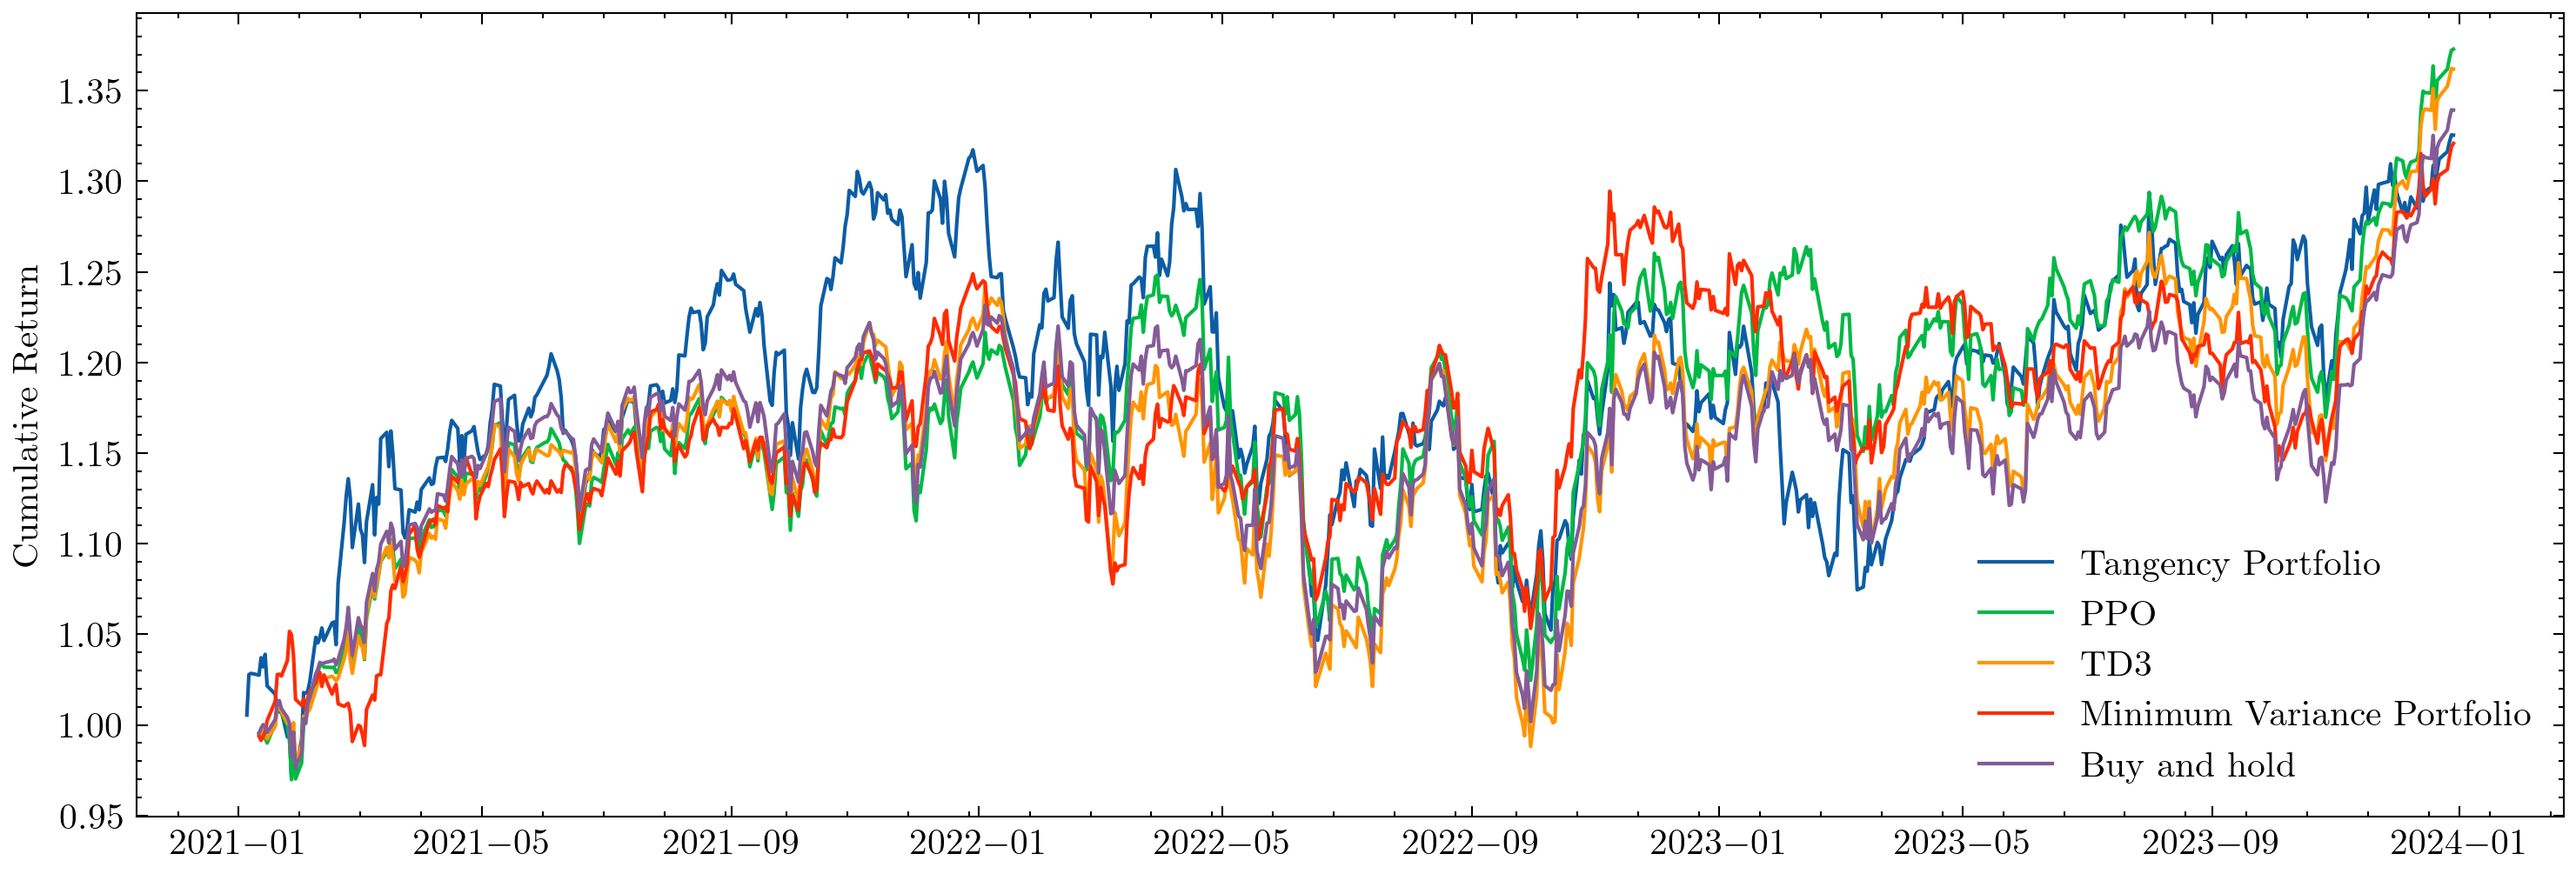

In [20]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe[0].get('date'),(result_sharpe[0]['account'].pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_test_result[0].get('date'),(ppo_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(td3_test_result[0].get('date'),(td3_test_result[0]['account'].pct_change() +1).cumprod(),label='TD3')
    plt.plot(min_variacen_portfolio[0].get('date'),(min_variacen_portfolio[0]['account'].pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dow_comparison.png', dpi=500)
    plt.show()

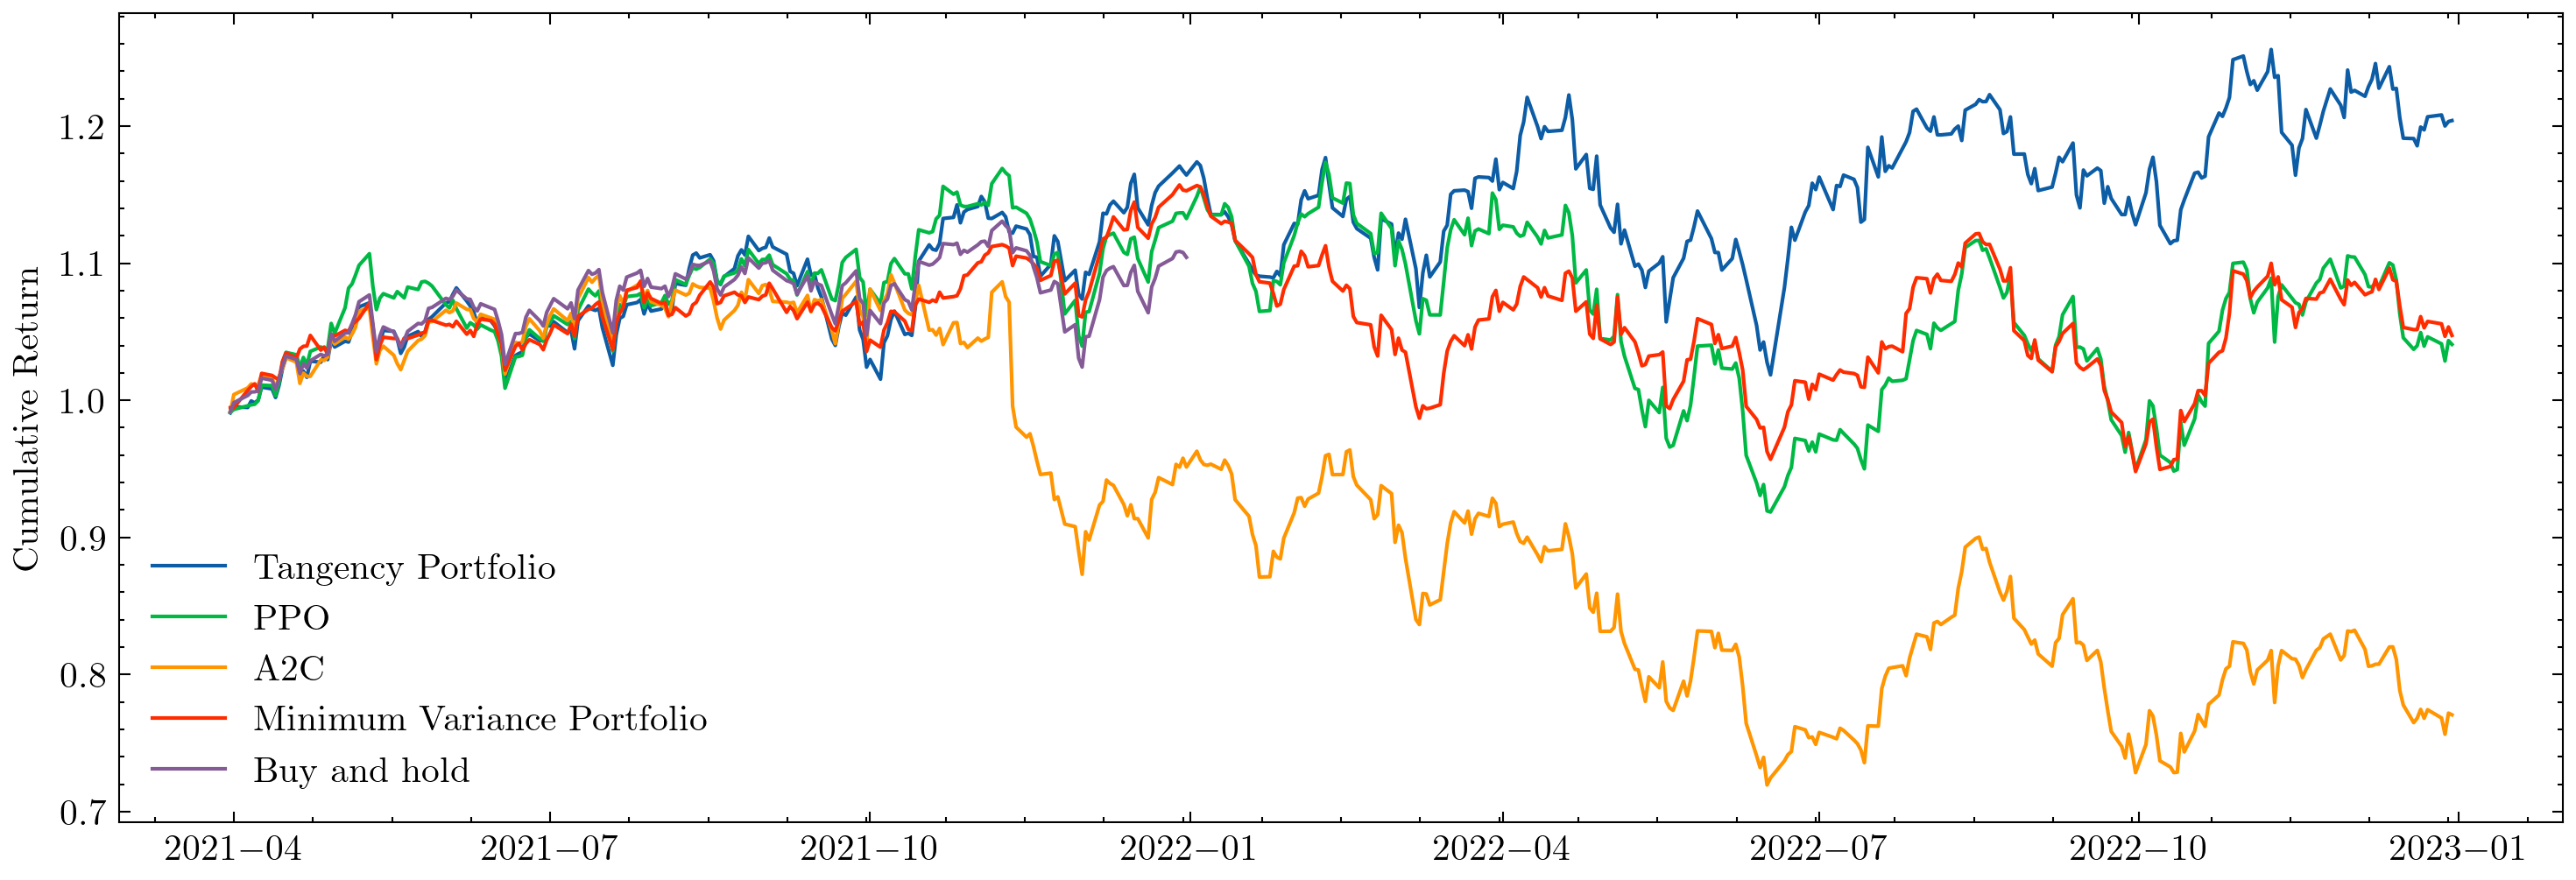

In [ ]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe['test'].date,(result_sharpe['test'].total_assets.pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_test_result[0].get('date'),(ppo_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(a2c_test_result[0].get('date'),(a2c_test_result[0]['account'].pct_change() +1).cumprod(),label='A2C')
    plt.plot(min_variacen_portfolio['test'].date,(min_variacen_portfolio['test'].total_assets.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dow_comparison.png', dpi=500)
    plt.show()

In [21]:
import quantstats as qs

In [22]:
ppo_returns = ppo_test_result[0][['date','account']]

ppo_stats={}
ppo_returns.set_index('date',inplace=True)
ppo_stats['name']  = 'Proximal Policy Optimization'
ppo_stats['sharpe_ratio'] = qs.stats.sharpe(ppo_returns)['account']
ppo_stats['max_drow_down'] = qs.stats.max_drawdown(ppo_returns)['account']
ppo_stats['var'] = qs.stats.var(ppo_returns)[0].item()
ppo_stats['return'] = qs.stats.comp(ppo_returns['account'].pct_change())
ppo_stats

{'name': 'Proximal Policy Optimization',
 'sharpe_ratio': np.float64(0.7257381726986925),
 'max_drow_down': np.float64(-0.17923042937422906),
 'var': -0.01671346800371344,
 'return': np.float64(0.37295050000000085)}

In [37]:
td3_returns = td3_test_result[0][['date','account']]

td3_stats={}
td3_returns.set_index('date',inplace=True)
td3_stats['name']  = 'TD3'
td3_stats['sharpe_ratio'] = qs.stats.sharpe(td3_returns)['account']
td3_stats['max_drow_down'] = qs.stats.max_drawdown(td3_returns)['account']
td3_stats['var'] = qs.stats.var(td3_returns)[0].item()
td3_stats['return'] = qs.stats.comp(td3_returns['account'].pct_change())
td3_stats

{'name': 'TD3',
 'sharpe_ratio': np.float64(0.6924094652778192),
 'max_drow_down': np.float64(-0.204997865874754),
 'var': -0.01727960060881399,
 'return': np.float64(0.3619546250000041)}

In [ ]:
mvo_min_returns = min_variacen_portfolio[0][['date','account']]
mvo_min_returns.set_index('date',inplace=True)

mvo_min_stats={}
mvo_min_stats['name']  = 'Min variance portfolio'
mvo_min_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_min_returns)['account']
mvo_min_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_min_returns)['account']
mvo_min_stats['var']  = qs.stats.var(mvo_min_returns)[0].item()
mvo_min_stats['return'] = qs.stats.comp(mvo_min_returns['account'].pct_change())
mvo_min_stats

{'name': 'Min variance portfolio',
 'sharpe_ratio': np.float64(0.7357437505756564),
 'max_drow_down': np.float64(-0.1566782761864729),
 'var': -0.014173361401397569,
 'return': np.float64(0.3209297500000017)}

In [27]:

mvo_sharpe_returns = result_sharpe[0][['date','account']]
mvo_sharpe_returns.set_index('date',inplace=True)
mvo_sharpe_stats={}
mvo_sharpe_stats['name']  = 'Tangency Portfolio'
mvo_sharpe_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_sharpe_returns)['account']
mvo_sharpe_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_sharpe_returns)['account']
mvo_sharpe_stats['var']  = qs.stats.var(mvo_sharpe_returns)[0].item()
mvo_sharpe_stats['return'] = qs.stats.comp(mvo_sharpe_returns['account'].pct_change())
mvo_sharpe_stats

{'name': 'Tangency Portfolio',
 'sharpe_ratio': np.float64(0.6153519351884738),
 'max_drow_down': np.float64(-0.20550034485798196),
 'var': -0.018146297382557727,
 'return': np.float64(0.32548899999999836)}

In [28]:
bh_df = pd.DataFrame()
bh_df['asset']=environment_train_buy_and_hold_sp500._portfolio_return_memory
bh_df['date']=environment_train_buy_and_hold_sp500._date_memory
bh_df.set_index('date',inplace=True)
bh_stats={}
bh_stats['name']  = 'Buy and Hold'
bh_stats['sharpe_ratio'] = qs.stats.sharpe(bh_df)['asset']
bh_stats['max_drow_down'] = qs.stats.max_drawdown(bh_df)['asset']
bh_stats['var'] = qs.stats.var(bh_df)[0].item()
bh_stats['return'] = qs.stats.comp(bh_df['asset'])

bh_stats

{'name': 'Buy and Hold',
 'sharpe_ratio': np.float64(0.6890450873214902),
 'max_drow_down': np.float64(-0.18659578165252866),
 'var': -0.016305387452884,
 'return': np.float64(0.33932155795551333)}

In [39]:
stats = [bh_stats,mvo_sharpe_stats,mvo_min_stats,ppo_stats,td3_stats]

In [40]:
stats_df = pd.DataFrame(stats)

In [41]:
stats_df

,name,sharpe_ratio,max_drow_down,var,return
0,Buy and Hold,0.689045,-0.186596,-0.016305,0.339322
1,Tangency Portfolio,0.615352,-0.205500,-0.018146,0.325489
2,Min variance portfolio,0.735744,-0.156678,-0.014173,0.320930
3,Proximal Policy Optimization,0.725738,-0.179230,-0.016713,0.372951
4,TD3,0.692409,-0.204998,-0.017280,0.361955


In [ ]:
with open('mytable.tex', 'w') as tf:
     tf.write(stats_df.to_latex())